In [3]:
!pip install pycaret

  Using cached pandas-2.1.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached pandas-2.1.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.3.3
    Uninstalling pandas-2.3.3:
      Successfully uninstalled pandas-2.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
spopt 0.7.0 requires scipy>=1.12.0, but you have scipy 1.11.4 which is incompatible.
plotnine 0.14.5 

In [4]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.core import error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
import joblib
import json
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')


In [5]:
df=pd.read_csv('/content/wfp_food_prices_ken.csv'
)
df.head()

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#loc+market+code,#geo+lat,#geo+lon,#item+type,#item+name,#item+code,#item+unit,#item+price+flag,#item+price+type,#currency+code,#value,#value+usd
1,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize,51,KG,actual,Wholesale,KES,16.13,0.22
2,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,17,0.24
4,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,90 KG,actual,Wholesale,KES,1800,25.03


In [6]:
df['commodity'].unique()

array(['#item+name', 'Maize', 'Beans', 'Maize (white)', 'Sorghum',
       'Oil (vegetable)', 'Beans (dry)', 'Potatoes (Irish)', 'Bread',
       'Milk (cow, pasteurized)', 'Fuel (kerosene)',
       'Fuel (petrol-gasoline)', 'Fuel (diesel)', 'Maize flour',
       'Wheat flour', 'Meat (beef)', 'Sugar', 'Bananas', 'Kale',
       'Tomatoes', 'Beans (kidney)', 'Beans (rosecoco)', 'Beans (yellow)',
       'Cabbage', 'Onions (dry)', 'Potatoes (Irish, white)',
       'Sorghum (red)', 'Beans (dolichos)', 'Spinach',
       'Maize (white, dry)', 'Beans (mung)', 'Millet (finger)',
       'Potatoes (Irish, red)', 'Rice (aromatic)',
       'Rice (imported, Pakistan)', 'Cowpeas', 'Cowpea leaves',
       'Sorghum (white)', 'Fish (omena, dry)', 'Salt',
       'Oil (vegetable, fortified)', 'Cowpeas (dry)',
       'Maize flour (white)', 'Pigeon peas (dry)', 'Rice', 'Milk (UHT)',
       'Cooking fat', 'Meat (goat)', 'Meat (camel)',
       'Milk (camel, fresh)', 'Milk (cow, fresh)'], dtype=object)

In [7]:
df['date']=pd.to_datetime(df['date'],errors='coerce')
print(df['date'].head(),
df['date'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 17439 entries, 0 to 17438
Series name: date
Non-Null Count  Dtype         
--------------  -----         
17438 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 136.4 KB
0          NaT
1   2006-01-15
2   2006-01-15
3   2006-01-15
4   2006-01-15
Name: date, dtype: datetime64[ns] None


In [8]:
df.shape

(17439, 16)

In [9]:
for col in df.columns:
  print(f"Missing values in {col}: {df[col].isna().sum()}")

Missing values in date: 1
Missing values in admin1: 41
Missing values in admin2: 41
Missing values in market: 0
Missing values in market_id: 0
Missing values in latitude: 41
Missing values in longitude: 41
Missing values in category: 0
Missing values in commodity: 0
Missing values in commodity_id: 0
Missing values in unit: 0
Missing values in priceflag: 0
Missing values in pricetype: 0
Missing values in currency: 0
Missing values in price: 0
Missing values in usdprice: 0


In [10]:
for col in df.columns:
  print(df[col].isna().sum())

1
41
41
0
0
41
41
0
0
0
0
0
0
0
0
0


In [11]:
df = df.dropna(subset=["date", "latitude", "longitude"])
df = df.sort_values("date")


In [12]:
df.shape

(17397, 16)

In [13]:
df.columns

Index(['date', 'admin1', 'admin2', 'market', 'market_id', 'latitude',
       'longitude', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice'],
      dtype='object')

In [14]:
df_pred = df.copy()
df_pred["date"] = pd.to_datetime(df_pred["date"], errors="coerce")
df_pred = df_pred.dropna(subset=["date", "price"])

df_pred = df_pred.sort_values("date").reset_index(drop=True)
df_pred.head()


,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize,51,KG,actual,Wholesale,KES,16.13,0.22
1,2006-01-15,Nairobi,Nairobi,Nairobi,184,-1.28,36.82,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,42.31,0.59
2,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,17,0.24
4,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,90 KG,actual,Wholesale,KES,1800,25.03


In [15]:
#PERISHABLE COMMODITIES
PERISHABLES = [
    "Tomatoes", "Onions (dry)", "Potatoes (Irish)",
    "Potatoes (Irish, white)", "Potatoes (Irish, red)",
    "Kale", "Spinach", "Cabbage", "Bananas"
]

df_pred = df_pred[df_pred["commodity"].isin(PERISHABLES)]



In [16]:
df_pred['commodity'].unique()

array(['Potatoes (Irish)', 'Bananas', 'Kale', 'Tomatoes',
       'Potatoes (Irish, white)', 'Cabbage', 'Onions (dry)', 'Spinach',
       'Potatoes (Irish, red)'], dtype=object)

In [17]:
df_pred.isna().sum()

,0
date,0
admin1,0
admin2,0
market,0
market_id,0
latitude,0
longitude,0
category,0
commodity,0
commodity_id,0


NO LTSM


In [18]:
#TIME BASED NON-LTSM
df_no_ltsm= df_pred.copy()

In [19]:
df_no_ltsm['year']=df_no_ltsm['date'].dt.year
df_no_ltsm['month']=df_no_ltsm['date'].dt.month
df_no_ltsm['quarter']=df_no_ltsm['date'].dt.quarter


In [20]:
df_no_ltsm.columns

Index(['date', 'admin1', 'admin2', 'market', 'market_id', 'latitude',
       'longitude', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice', 'year',
       'month', 'quarter'],
      dtype='object')

In [21]:
df_no_ltsm["sin_month"] = np.sin(2 * np.pi * df_no_ltsm["month"] / 12)
df_no_ltsm["cos_month"] = np.cos(2 * np.pi * df_no_ltsm["month"] / 12)
df_no_ltsm.columns

Index(['date', 'admin1', 'admin2', 'market', 'market_id', 'latitude',
       'longitude', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice', 'year',
       'month', 'quarter', 'sin_month', 'cos_month'],
      dtype='object')

In [22]:
df_no_ltsm.isna().sum()

,0
date,0
admin1,0
admin2,0
market,0
market_id,0
latitude,0
longitude,0
category,0
commodity,0
commodity_id,0


In [23]:
df_no_ltsm.head()

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,...,priceflag,pricetype,currency,price,usdprice,year,month,quarter,sin_month,cos_month
10,2006-01-15,Nyanza,Kisumu,Kisumu,186,-0.1,34.75,cereals and tubers,Potatoes (Irish),148,...,actual,Wholesale,KES,1074.07,14.94,2006,1,1,0.500000,8.660254e-01
20,2006-02-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,...,actual,Wholesale,KES,1555.55,21.7,2006,2,1,0.866025,5.000000e-01
33,2006-03-15,Nairobi,Nairobi,Nairobi,184,-1.28,36.82,cereals and tubers,Potatoes (Irish),148,...,actual,Wholesale,KES,961.11,13.28,2006,3,1,1.000000,6.123234e-17
37,2006-03-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,...,actual,Wholesale,KES,1722.21,23.8,2006,3,1,1.000000,6.123234e-17
49,2006-03-15,Nyanza,Kisumu,Kisumu,186,-0.1,34.75,cereals and tubers,Potatoes (Irish),148,...,actual,Wholesale,KES,1872.91,25.89,2006,3,1,1.000000,6.123234e-17


In [24]:
group_cols = ["commodity", "market"]

df_no_ltsm["price_lag_1"] = df_no_ltsm.groupby(group_cols)["price"].shift(1)
df_no_ltsm["price_lag_3"] = df_no_ltsm.groupby(group_cols)["price"].shift(3)
df_no_ltsm["price_lag_6"] = df_no_ltsm.groupby(group_cols)["price"].shift(6)

df_no_ltsm["price_ma_3"] = df_no_ltsm.groupby(group_cols)["price"].rolling(3).mean().reset_index(level=group_cols, drop=True)
df_no_ltsm["price_ma_6"] = df_no_ltsm.groupby(group_cols)["price"].rolling(6).mean().reset_index(level=group_cols, drop=True)

df_no_ltsm["price_vol_6"] = df_no_ltsm.groupby(group_cols)["price"].rolling(6).std().reset_index(level=group_cols, drop=True)
print(df_no_ltsm.columns)



Index(['date', 'admin1', 'admin2', 'market', 'market_id', 'latitude',
       'longitude', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice', 'year',
       'month', 'quarter', 'sin_month', 'cos_month', 'price_lag_1',
       'price_lag_3', 'price_lag_6', 'price_ma_3', 'price_ma_6',
       'price_vol_6'],
      dtype='object')


In [25]:

 df_no_ltsm.isna().sum()

,0
date,0
admin1,0
admin2,0
market,0
market_id,0
latitude,0
longitude,0
category,0
commodity,0
commodity_id,0


In [26]:
df_no_ltsm=df_no_ltsm.dropna().reset_index(drop=True)

In [27]:
df_no_ltsm.isna().sum()

,0
date,0
admin1,0
admin2,0
market,0
market_id,0
latitude,0
longitude,0
category,0
commodity,0
commodity_id,0


In [28]:
df_no_ltsm.shape

(1886, 27)

In [29]:
df_no_ltsm.head()

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,...,month,quarter,sin_month,cos_month,price_lag_1,price_lag_3,price_lag_6,price_ma_3,price_ma_6,price_vol_6
0,2006-12-15,Rift Valley,Uasin Gishu,Eldoret town (Uasin Gishu),185,0.52,35.28,cereals and tubers,Potatoes (Irish),148,...,12,4,-2.449294e-16,1.000000,736.11,468.51,875.97,637.590000,527.535000,141.538351
1,2007-01-15,Nairobi,Nairobi,Nairobi,184,-1.28,36.82,cereals and tubers,Potatoes (Irish),148,...,1,1,5.000000e-01,0.866025,1122.22,555.55,961.11,1035.736667,864.346667,338.294224
2,2007-01-15,Rift Valley,Uasin Gishu,Eldoret town (Uasin Gishu),185,0.52,35.28,cereals and tubers,Potatoes (Irish),148,...,1,1,5.000000e-01,0.866025,555.55,621.11,450.61,655.553333,564.933333,146.698454
3,2007-02-15,Nairobi,Nairobi,Nairobi,184,-1.28,36.82,cereals and tubers,Potatoes (Irish),148,...,2,1,8.660254e-01,0.500000,1402.77,582.22,861.1,1356.476667,978.236667,437.471306
4,2007-02-15,Rift Valley,Uasin Gishu,Eldoret town (Uasin Gishu),185,0.52,35.28,cereals and tubers,Potatoes (Irish),148,...,2,1,8.660254e-01,0.500000,675,736.11,333.32,571.976667,590.276667,106.237914


In [30]:
df_no_ltsm['category'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1886 entries, 0 to 1885
Series name: category
Non-Null Count  Dtype 
--------------  ----- 
1886 non-null   object
dtypes: object(1)
memory usage: 14.9+ KB


In [31]:
df_no_ltsm['category'].unique()

array(['cereals and tubers', 'vegetables and fruits'], dtype=object)

In [32]:
df_no_ltsm.columns

Index(['date', 'admin1', 'admin2', 'market', 'market_id', 'latitude',
       'longitude', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice', 'year',
       'month', 'quarter', 'sin_month', 'cos_month', 'price_lag_1',
       'price_lag_3', 'price_lag_6', 'price_ma_3', 'price_ma_6',
       'price_vol_6'],
      dtype='object')

In [47]:
df_model['price_lag_1']

,price_lag_1
0,736.11
1,1122.22
2,555.55
3,1402.77
4,675.00
...,...
1881,20.00
1882,20.00
1883,20.00
1884,70.00


In [ ]:
df_model['price_lag_6'] =

In [ ]:
# Check the current dtype of price column
print("Price column dtype:", df_no_ltsm['price'].dtype)
print("Sample price values:", df_no_ltsm['price'].head())

# Convert price and all lag features to numeric
df_no_ltsm['price'] = pd.to_numeric(df_no_ltsm['price'], errors='coerce')
df_no_ltsm['price_lag_1'] = pd.to_numeric(df_no_ltsm['price_lag_1'], errors='coerce')
df_no_ltsm['price_lag_3'] = pd.to_numeric(df_no_ltsm['price_lag_3'], errors='coerce')
df_no_ltsm['price_lag_6'] = pd.to_numeric(df_no_ltsm['price_lag_6'], errors='coerce')

# Check if there are any NaN values created by conversion
print("\nMissing values after conversion:")
print(df_no_ltsm[['price', 'price_lag_1', 'price_lag_3', 'price_lag_6']].isna().sum())

# Drop any rows with NaN in these columns
df_no_ltsm = df_no_ltsm.dropna(subset=['price', 'price_lag_1', 'price_lag_3', 'price_lag_6'])

# Verify the fix
print("\nAfter fixing:")
df_no_ltsm.info()

In [48]:
# Check the cardinality (number of unique values)
print("Unique values:")
print(f"admin1: {df_no_ltsm['admin1'].nunique()}")
print(f"admin2: {df_no_ltsm['admin2'].nunique()}")
print(f"market: {df_no_ltsm['market'].nunique()}")
print(f"\nTotal rows: {len(df_no_ltsm)}")

# Check correlation between admin2 and market
print("\nSample data:")
print(df_no_ltsm[['admin1', 'admin2', 'market', 'latitude', 'longitude']].head(10))

Unique values:
admin1: 7
admin2: 16
market: 40

Total rows: 1886

Sample data:
        admin1       admin2                      market latitude longitude
0  Rift Valley  Uasin Gishu  Eldoret town (Uasin Gishu)     0.52     35.28
1      Nairobi      Nairobi                     Nairobi    -1.28     36.82
2  Rift Valley  Uasin Gishu  Eldoret town (Uasin Gishu)     0.52     35.28
3      Nairobi      Nairobi                     Nairobi    -1.28     36.82
4  Rift Valley  Uasin Gishu  Eldoret town (Uasin Gishu)     0.52     35.28
5      Nairobi      Nairobi                     Nairobi    -1.28     36.82
6       Nyanza       Kisumu                      Kisumu     -0.1     34.75
7  Rift Valley  Uasin Gishu  Eldoret town (Uasin Gishu)     0.52     35.28
8      Nairobi      Nairobi                     Nairobi    -1.28     36.82
9       Nyanza       Kisumu                      Kisumu     -0.1     34.75


In [34]:
# Drop admin2 (redundant), keep admin1 and market
DROP_COLS = ['date', 'market_id', 'commodity_id', 'currency', 'usdprice',
             'priceflag', 'admin2']

# Categorical columns to encode
CATEGORICAL_COLS = ['admin1', 'market', 'category', 'commodity', 'unit', 'pricetype']

# Process the data
df_model = df_no_ltsm.drop(columns=DROP_COLS)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in CATEGORICAL_COLS:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

# Convert numeric columns explicitly
numeric_cols = ['latitude', 'longitude', 'price', 'year', 'month', 'quarter',
                'sin_month', 'cos_month', 'price_lag_1', 'price_lag_3',
                'price_lag_6', 'price_ma_3', 'price_ma_6', 'price_vol_6']

for col in numeric_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Drop any remaining NaN
df_model = df_model.dropna()

print("Final feature set:")
print(df_model.columns.tolist())
print(f"\nShape: {df_model.shape}")
print(f"\nData types:\n{df_model.dtypes}")

# Verify no object types remain
assert df_model.select_dtypes(include=['object']).shape[1] == 0, "Still have object columns!"
print("\n✅ All columns are numeric - ready for modeling!")

Final feature set:
['admin1', 'market', 'latitude', 'longitude', 'category', 'commodity', 'unit', 'pricetype', 'price', 'year', 'month', 'quarter', 'sin_month', 'cos_month', 'price_lag_1', 'price_lag_3', 'price_lag_6', 'price_ma_3', 'price_ma_6', 'price_vol_6']

Shape: (1886, 20)

Data types:
admin1           int64
market           int64
latitude       float64
longitude      float64
category         int64
commodity        int64
unit             int64
pricetype        int64
price          float64
year             int32
month            int32
quarter          int32
sin_month      float64
cos_month      float64
price_lag_1    float64
price_lag_3    float64
price_lag_6    float64
price_ma_3     float64
price_ma_6     float64
price_vol_6    float64
dtype: object

✅ All columns are numeric - ready for modeling!


Split

In [35]:
# Check distribution
print("\nSamples per market (top 10):")
market_counts = df_no_ltsm.groupby('market').size().sort_values(ascending=False)
print(market_counts.head(10))

print("\nCommodities per market:")
commodity_market = df_no_ltsm.groupby('market')['commodity'].nunique()
print(commodity_market.describe())


Samples per market (top 10):
market
Eldoret town (Uasin Gishu)    243
Nairobi                       109
Kisumu                        106
Kitui                          86
Wakulima (Nakuru)              75
Garissa town (Garissa)         75
Kangemi (Nairobi)              70
Karatina (Nyeri)               69
Kitengela (Kajiado)            64
Kibuye (Kisumu)                64
dtype: int64

Commodities per market:
count    40.000000
mean      3.175000
std       1.893139
min       1.000000
25%       2.000000
50%       2.000000
75%       5.000000
max       7.000000
Name: commodity, dtype: float64


In [ ]:
df['market'].unique()

In [ ]:
!pip install shap

  Using cached scipy-1.11.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.11.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.8 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
opencv-contrib-python 4.12.0.88 r

Generating SHAP summary plot...


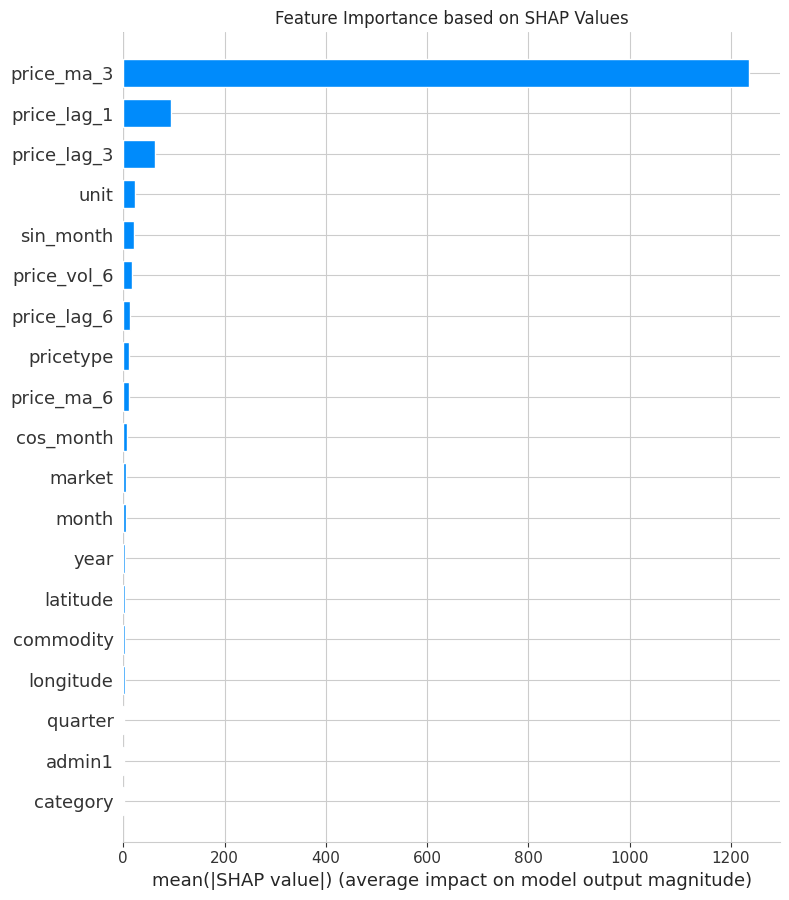

Generating SHAP dependence plots...


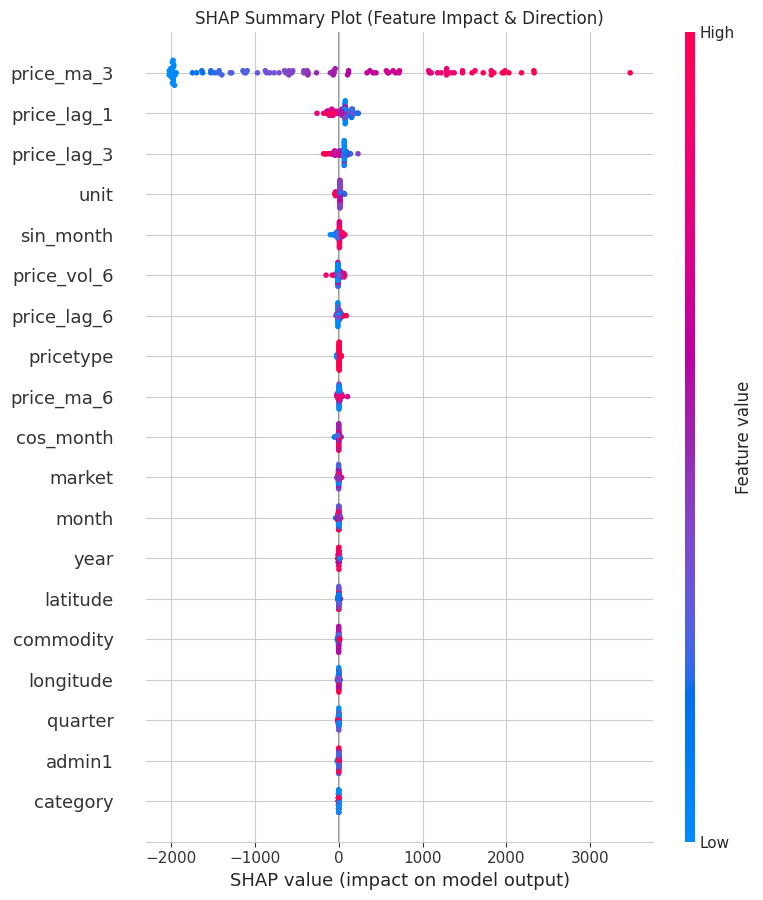

In [46]:

import shap

# Get the best model (Random Forest) and a subset of the data for explanation
best_model = results[best_model_name]['model']

# Use a subset of the training data for SHAP explanation, as it can be computationally intensive
# For simplicity, let's use a small sample of X_train
X_sample = X_train.sample(n=100, random_state=42) # Adjust n as needed

# Create a SHAP explainer object for the Random Forest model
# shap.TreeExplainer is optimized for tree-based models
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the sampled data
shap_values = explainer.shap_values(X_sample)

# Visualize the feature importance (mean absolute SHAP value)
# This plot summarizes the impact of each feature on model output magnitude
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Feature Importance based on SHAP Values")
plt.tight_layout()
plt.show()

# Also visualize the summary plot showing feature impact and direction
print("Generating SHAP dependence plots...")
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary Plot (Feature Impact & Direction)")
plt.tight_layout()
plt.show()

In [ ]:
# Best model was already determined and stored in results dictionary
best_model_name = min(results, key=lambda x: results[x]['test_mae'])
best_model = results[best_model_name]['model']

print(f"Model Type: {type(best_model)}")
print("\nModel Parameters:")
print(best_model.get_params())
print("\nInput Features (columns used for training):")
print(X.columns.tolist())

Regarding your second question about forecasting the next month, yes, the next step after understanding the model would typically be to prepare input data for the next month and use the `best_model.predict()` function. This would involve creating a new DataFrame with the features for the future date, just as we prepared `X_test` from historical data.

In [39]:
df_model['commodity'].unique()

array([4, 6, 0, 3, 1, 7, 2, 5])

In [38]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   admin1       1886 non-null   int64  
 1   market       1886 non-null   int64  
 2   latitude     1886 non-null   float64
 3   longitude    1886 non-null   float64
 4   category     1886 non-null   int64  
 5   commodity    1886 non-null   int64  
 6   unit         1886 non-null   int64  
 7   pricetype    1886 non-null   int64  
 8   price        1886 non-null   float64
 9   year         1886 non-null   int32  
 10  month        1886 non-null   int32  
 11  quarter      1886 non-null   int32  
 12  sin_month    1886 non-null   float64
 13  cos_month    1886 non-null   float64
 14  price_lag_1  1886 non-null   float64
 15  price_lag_3  1886 non-null   float64
 16  price_lag_6  1886 non-null   float64
 17  price_ma_3   1886 non-null   float64
 18  price_ma_6   1886 non-null   float64
 19  price_

In [37]:
feature_cols=[col for col in df_model.columns if col !='price']
X=df_model[feature_cols]
y=df_model['price']

In [ ]:
X.shape

In [ ]:
y.shape

In [40]:
from sklearn.model_selection import TimeSeriesSplit

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print("TimeSeriesSplit configuration:")
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {i+1}: Train={len(train_idx)}, Test={len(test_idx)}")

TimeSeriesSplit configuration:
Fold 1: Train=316, Test=314
Fold 2: Train=630, Test=314
Fold 3: Train=944, Test=314
Fold 4: Train=1258, Test=314
Fold 5: Train=1572, Test=314


In [41]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score

# Define models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15,
                                           min_samples_split=5, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                                random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5,
                                                    learning_rate=0.1, random_state=42),
}

# TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)
results = {}

print("🚀 Training with TimeSeriesSplit Cross-Validation...\n")

for name, model in models.items():
    print(f"Training {name}...")

    # Cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=tscv,
                                scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()

    # Train on full training set and evaluate on final test set
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    results[name] = {
        'cv_mae': cv_mae,
        'cv_std': cv_std,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'test_mape': test_mape,
        'model': model
    }

    print(f"  CV MAE:    {cv_mae:.2f} (±{cv_std:.2f})")
    print(f"  Test MAE:  {test_mae:.2f}")
    print(f"  Test RMSE: {test_rmse:.2f}")
    print(f"  Test R²:   {test_r2:.4f}")
    print(f"  Test MAPE: {test_mape:.2f}%")
    print()

# Best model
best_model_name = min(results, key=lambda x: results[x]['test_mae'])
best_model = results[best_model_name]['model']

print(f"🏆 Best Model: {best_model_name}")
print(f"   CV MAE:   {results[best_model_name]['cv_mae']:.2f}")
print(f"   Test MAE: {results[best_model_name]['test_mae']:.2f}")

🚀 Training with TimeSeriesSplit Cross-Validation...

Training Random Forest...
  CV MAE:    291.51 (±95.29)
  Test MAE:  164.06
  Test RMSE: 444.64
  Test R²:   0.9343
  Test MAPE: 10.58%

Training XGBoost...
  CV MAE:    317.31 (±116.08)
  Test MAE:  192.21
  Test RMSE: 510.85
  Test R²:   0.9133
  Test MAPE: 24.72%

Training Gradient Boosting...
  CV MAE:    303.57 (±100.92)
  Test MAE:  184.13
  Test RMSE: 508.12
  Test R²:   0.9143
  Test MAPE: 25.17%

🏆 Best Model: Random Forest
   CV MAE:   291.51
   Test MAE: 164.06


In [ ]:
!pip install nolds

In [44]:
import nolds

# Ensure the price column is numeric and handle any potential non-finite values
prices = pd.to_numeric(df_no_ltsm['price'], errors='coerce').dropna()

# Calculate the Hurst exponent
hurst_exponent = nolds.hurst_rs(prices)

print(f"The Hurst Exponent for the 'price' column is: {hurst_exponent:.4f}")

The Hurst Exponent for the 'price' column is: 0.6599


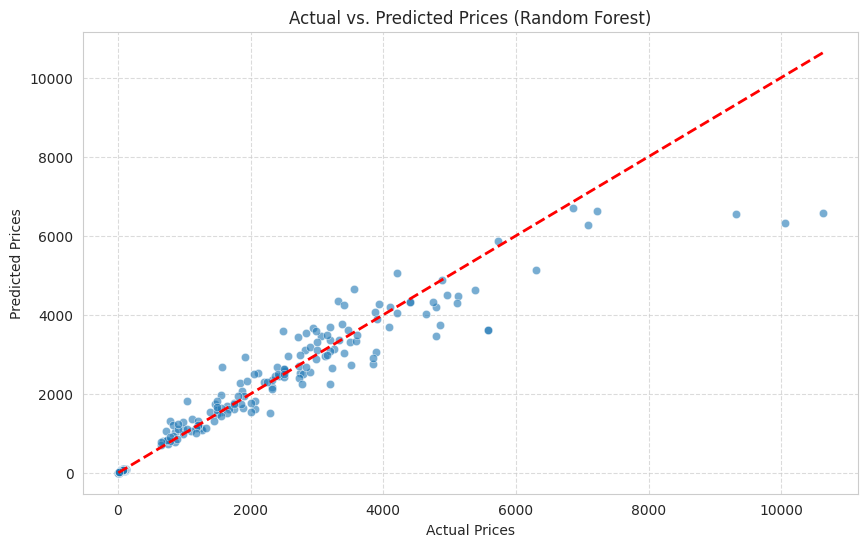

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the best model and test data
best_model = results[best_model_name]['model']
X_test = X[split_idx:]
y_test = y[split_idx:]

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Line for perfect predictions
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs. Predicted Prices ({best_model_name})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
print('hello')

In [ ]:
X_test.head()

In [50]:
X_train.columns

Index(['admin1', 'market', 'latitude', 'longitude', 'category', 'commodity',
       'unit', 'pricetype', 'year', 'month', 'quarter', 'sin_month',
       'cos_month', 'price_lag_1', 'price_lag_3', 'price_lag_6', 'price_ma_3',
       'price_ma_6', 'price_vol_6'],
      dtype='object')

# Task
Predict the next month's prices for each 'admin1', 'market', and 'commodity' combination, using the previously trained `best_model`. This involves preparing a future DataFrame (`X_future`) by extracting unique combinations, defining the next prediction date, generating time-based features, calculating lagged and moving average features based on the last known actual prices from `df_no_ltsm`, and encoding categorical features using the existing `label_encoders`, and then making and displaying the predictions.

## Prepare Future Data Structure

### Subtask:
Identify unique combinations of 'admin1', 'market', and 'commodity' from the historical data and define the next prediction date.


**Reasoning**:
To prepare for future predictions, I need to identify the unique combinations of 'admin1', 'market', and 'commodity' from the processed historical data (`df_model`), determine the latest date from the original `df_no_ltsm` to calculate the next prediction date, and then create a template DataFrame for these future predictions.



In [51]:
unique_combinations = df_model[['admin1', 'market', 'commodity']].drop_duplicates().reset_index(drop=True)

latest_date = df_no_ltsm['date'].max()
next_prediction_date = latest_date + pd.DateOffset(months=1)

X_future_template = unique_combinations.copy()
X_future_template['date'] = next_prediction_date

print("Unique combinations of admin1, market, commodity:\n", unique_combinations.head())
print(f"\nLatest historical date: {latest_date}")
print(f"Next prediction date: {next_prediction_date}")
print("\nX_future_template head:\n", X_future_template.head())
print("\nX_future_template shape:", X_future_template.shape)

Unique combinations of admin1, market, commodity:
    admin1  market  commodity
0       6       2          4
1       3      34          4
2       5      23          4
3       2      25          4
4       6      35          4

Latest historical date: 2025-11-15 00:00:00
Next prediction date: 2025-12-15 00:00:00

X_future_template head:
    admin1  market  commodity       date
0       6       2          4 2025-12-15
1       3      34          4 2025-12-15
2       5      23          4 2025-12-15
3       2      25          4 2025-12-15
4       6      35          4 2025-12-15

X_future_template shape: (127, 4)


## Generate Time-Based Features for Future Data

### Subtask:
For the identified future prediction date, generate the time-based features: 'year', 'month', 'quarter', 'sin_month', and 'cos_month'.


**Reasoning**:
To prepare the `X_future_template` DataFrame for prediction, I need to extract and create the time-based features 'year', 'month', 'quarter', 'sin_month', and 'cos_month' from its 'date' column, as done for the training data.



In [52]:
X_future_template['year'] = X_future_template['date'].dt.year
X_future_template['month'] = X_future_template['date'].dt.month
X_future_template['quarter'] = X_future_template['date'].dt.quarter
X_future_template['sin_month'] = np.sin(2 * np.pi * X_future_template['month'] / 12)
X_future_template['cos_month'] = np.cos(2 * np.pi * X_future_template['month'] / 12)

print("Time-based features generated for X_future_template:")
print(X_future_template.head())

Time-based features generated for X_future_template:
   admin1  market  commodity       date  year  month  quarter     sin_month  \
0       6       2          4 2025-12-15  2025     12        4 -2.449294e-16   
1       3      34          4 2025-12-15  2025     12        4 -2.449294e-16   
2       5      23          4 2025-12-15  2025     12        4 -2.449294e-16   
3       2      25          4 2025-12-15  2025     12        4 -2.449294e-16   
4       6      35          4 2025-12-15  2025     12        4 -2.449294e-16   

   cos_month  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  


## Calculate Lagged and Moving Average Features for Prediction

### Subtask:
Calculate 'price_lag_1', 'price_lag_3', 'price_lag_6', 'price_ma_3', 'price_ma_6', and 'price_vol_6' for the future prediction date by utilizing the last known actual prices from `df_no_ltsm` for each 'commodity' and 'market' combination, and merge these features into `X_future_template`.


**Reasoning**:
To calculate the lagged and moving average features for `X_future_template`, I need to prepare a temporary DataFrame `df_no_ltsm_encoded` by encoding the categorical columns in `df_no_ltsm` using the previously fitted `label_encoders`. This ensures consistency in categorical variable representation.



In [53]:
df_no_ltsm_encoded = df_no_ltsm.copy()
for col in CATEGORICAL_COLS:
    df_no_ltsm_encoded[col] = label_encoders[col].transform(df_no_ltsm_encoded[col].astype(str))

print("df_no_ltsm_encoded head with encoded categorical features:")
print(df_no_ltsm_encoded.head())

df_no_ltsm_encoded head with encoded categorical features:
        date  admin1       admin2  market market_id latitude longitude  \
0 2006-12-15       6  Uasin Gishu       2       185     0.52     35.28   
1 2007-01-15       3      Nairobi      34       184    -1.28     36.82   
2 2007-01-15       6  Uasin Gishu       2       185     0.52     35.28   
3 2007-02-15       3      Nairobi      34       184    -1.28     36.82   
4 2007-02-15       6  Uasin Gishu       2       185     0.52     35.28   

   category  commodity commodity_id  ...  month quarter     sin_month  \
0         0          4          148  ...     12       4 -2.449294e-16   
1         0          4          148  ...      1       1  5.000000e-01   
2         0          4          148  ...      1       1  5.000000e-01   
3         0          4          148  ...      2       1  8.660254e-01   
4         0          4          148  ...      2       1  8.660254e-01   

  cos_month price_lag_1 price_lag_3  price_lag_6   price_

**Reasoning**:
To prepare `X_future_template` for prediction, I need to calculate the lagged and moving average features. This involves initializing these columns in `X_future_template` to `np.nan`, then iterating through each unique combination of `admin1`, `market`, and `commodity` in `X_future_template`. For each combination, I will retrieve the relevant historical data from `df_no_ltsm_encoded`, sort it by date, and then compute the required lag, moving average, and volatility features based on the last known `price` values. Finally, I will display the updated `X_future_template` to show the newly added features.



**Reasoning**:
The TypeError: ufunc 'divide' not supported' indicates that the 'price' column, after filtering, was not being treated as a numeric type when calculating `np.mean` and `np.std`. To fix this, I will explicitly convert the 'price' column in the `historical_data` DataFrame to a numeric type using `pd.to_numeric` before performing calculations.



In [55]:
import numpy as np

# Initialize lag and MA features in X_future_template with NaN
lag_ma_cols = ['price_lag_1', 'price_lag_3', 'price_lag_6', 'price_ma_3', 'price_ma_6', 'price_vol_6']
for col in lag_ma_cols:
    X_future_template[col] = np.nan

# Sort df_no_ltsm_encoded by date to ensure correct lag calculation
df_no_ltsm_encoded = df_no_ltsm_encoded.sort_values('date').reset_index(drop=True)

# Iterate through each row in X_future_template to calculate future features
for index, row in X_future_template.iterrows():
    admin1_val = row['admin1']
    market_val = row['market']
    commodity_val = row['commodity']

    # Filter historical data for the current combination
    historical_data = df_no_ltsm_encoded[
        (df_no_ltsm_encoded['admin1'] == admin1_val) &
        (df_no_ltsm_encoded['market'] == market_val) &
        (df_no_ltsm_encoded['commodity'] == commodity_val)
    ].copy()

    # Ensure historical_data is sorted by date
    historical_data = historical_data.sort_values('date')

    if not historical_data.empty:
        # Explicitly convert 'price' to numeric to avoid TypeError
        historical_data['price'] = pd.to_numeric(historical_data['price'], errors='coerce')
        historical_data = historical_data.dropna(subset=['price']) # Drop any rows where price could not be converted

        last_prices = historical_data['price'].values

        # Calculate lag features
        if len(last_prices) >= 1:
            X_future_template.loc[index, 'price_lag_1'] = last_prices[-1]
        if len(last_prices) >= 3:
            X_future_template.loc[index, 'price_lag_3'] = last_prices[-3]
        if len(last_prices) >= 6:
            X_future_template.loc[index, 'price_lag_6'] = last_prices[-6]

        # Calculate moving average features
        if len(last_prices) >= 3:
            X_future_template.loc[index, 'price_ma_3'] = np.mean(last_prices[-3:])
        if len(last_prices) >= 6:
            X_future_template.loc[index, 'price_ma_6'] = np.mean(last_prices[-6:])

        # Calculate price volatility (standard deviation)
        if len(last_prices) >= 6 and len(np.unique(last_prices[-6:])) > 1: # Ensure more than one unique value for meaningful std dev
            X_future_template.loc[index, 'price_vol_6'] = np.std(last_prices[-6:])
        elif len(last_prices) >= 6 and len(np.unique(last_prices[-6:])) == 1:
            X_future_template.loc[index, 'price_vol_6'] = 0.0 # If all values are the same, std dev is 0


print("X_future_template with lag and moving average features:")
print(X_future_template.head())

X_future_template with lag and moving average features:
   admin1  market  commodity       date  year  month  quarter     sin_month  \
0       6       2          4 2025-12-15  2025     12        4 -2.449294e-16   
1       3      34          4 2025-12-15  2025     12        4 -2.449294e-16   
2       5      23          4 2025-12-15  2025     12        4 -2.449294e-16   
3       2      25          4 2025-12-15  2025     12        4 -2.449294e-16   
4       6      35          4 2025-12-15  2025     12        4 -2.449294e-16   

   cos_month  price_lag_1  price_lag_3  price_lag_6   price_ma_3   price_ma_6  \
0        1.0      1813.33      1916.25        872.5  1860.693333  1536.263333   
1        1.0        61.00      2300.00       2500.0  1698.110000  2082.388333   
2        1.0      2400.00      2490.00       1494.0  2430.000000  2121.541667   
3        1.0      3500.00      3050.00       2850.0  3200.000000  3358.333333   
4        1.0      2625.00      2647.50       1440.0  2590.833333

**Reasoning**:
The next step is to ensure that all necessary features are present in `X_future_template` and that their data types match those used for training the `best_model`. This includes adding `latitude` and `longitude` to `X_future_template` and confirming that all categorical columns are correctly encoded, and then ensuring all columns are numeric.



In [56]:
X_future = X_future_template.copy()

# Add 'latitude' and 'longitude' by merging with the original df_model or df_no_ltsm_encoded
# Since admin1, market are encoded, we need to merge on them.
# We can take the last known latitude/longitude for each admin1, market combination.
# Group by admin1, market, and take the mean/first/last latitude/longitude
lat_lon_map = df_model[['admin1', 'market', 'latitude', 'longitude']].drop_duplicates().set_index(['admin1', 'market'])
X_future = X_future.join(lat_lon_map, on=['admin1', 'market'], how='left')

# Encode other categorical features ('category', 'unit', 'pricetype')
# These need to be joined from the historical data or a mapping needs to be applied.
# For 'category', 'unit', 'pricetype', we need to decide how to handle them for future predictions.
# A simple approach is to take the mode from the historical data for each commodity or market.
# However, it's safer to ensure these are part of the 'unique_combinations' if they define distinct predictions.
# Let's assume for now that for each commodity-market pair, these are consistent, and we can map them.

# Create mappings for category, unit, pricetype from df_no_ltsm_encoded based on commodity
commodity_category_map = df_no_ltsm_encoded.groupby('commodity')['category'].first().to_dict()
commodity_unit_map = df_no_ltsm_encoded.groupby('commodity')['unit'].first().to_dict()
commodity_pricetype_map = df_no_ltsm_encoded.groupby('commodity')['pricetype'].first().to_dict()

X_future['category'] = X_future['commodity'].map(commodity_category_map)
X_future['unit'] = X_future['commodity'].map(commodity_unit_map)
X_future['pricetype'] = X_future['commodity'].map(commodity_pricetype_map)

# Ensure all columns are numeric and match the training set X.columns
# Drop the 'date' column as it's no longer needed for the model input
X_future = X_future.drop(columns=['date'])

# Reorder columns to match X_train used by the model
X_future = X_future[X.columns]

print("Final X_future head:")
print(X_future.head())
print("\nFinal X_future shape:", X_future.shape)
print("\nX_future columns and dtypes:")
print(X_future.info())


Final X_future head:
   admin1  market  latitude  longitude  category  commodity  unit  pricetype  \
0       6       2      0.52      35.28         0          4     2          1   
1       3      34     -1.28      36.82         0          4     2          1   
2       5      23     -0.10      34.75         0          4     2          1   
3       2      25     -1.37      38.02         0          4     2          1   
4       6      35     -0.28      36.07         0          4     2          1   

   year  month  quarter     sin_month  cos_month  price_lag_1  price_lag_3  \
0  2025     12        4 -2.449294e-16        1.0      1813.33      1916.25   
1  2025     12        4 -2.449294e-16        1.0        61.00      2300.00   
2  2025     12        4 -2.449294e-16        1.0      2400.00      2490.00   
3  2025     12        4 -2.449294e-16        1.0      3500.00      3050.00   
4  2025     12        4 -2.449294e-16        1.0      2625.00      2647.50   

   price_lag_6   price_ma_3  

**Reasoning**:
The `X_future` DataFrame still contains `NaN` values in some feature columns (price lags, moving averages, and volatility) as indicated by `X_future.info()`. The `best_model` (RandomForestRegressor) cannot handle `NaN` values, so these rows must be dropped before making predictions. After ensuring the data is clean, the next logical step is to use the trained `best_model` to predict prices for the next month based on the prepared `X_future` features. Finally, the predictions will be displayed, ideally with their corresponding `admin1`, `market`, and `commodity` to provide context.



In [57]:
import pandas as pd

# Drop rows with NaN values in X_future, which might exist if there wasn't enough historical data for lags/MAs
X_future_cleaned = X_future.dropna().copy()

# Store the original identifiers for display later
X_future_identifiers = X_future_template[['admin1', 'market', 'commodity', 'date']].loc[X_future_cleaned.index].copy()

# Make predictions using the best model
future_predictions = best_model.predict(X_future_cleaned)

# Add predictions to a DataFrame along with identifiers
X_future_identifiers['predicted_price'] = future_predictions

# Decode admin1, market, and commodity for better readability
for col in ['admin1', 'market', 'commodity']:
    # Ensure the column exists in the label_encoders and in X_future_identifiers
    if col in label_encoders and col in X_future_identifiers.columns:
        # Check if the inverse_transform method is callable and works with the dtype
        # Convert to int if necessary before inverse_transform
        X_future_identifiers[col] = label_encoders[col].inverse_transform(X_future_identifiers[col].astype(int))

print("Predicted prices for the next month:")
print(X_future_identifiers.head(10))

Predicted prices for the next month:
           admin1                      market                commodity  \
0     Rift Valley  Eldoret town (Uasin Gishu)         Potatoes (Irish)   
1         Nairobi                     Nairobi         Potatoes (Irish)   
2          Nyanza                      Kisumu         Potatoes (Irish)   
3         Eastern                       Kitui         Potatoes (Irish)   
4     Rift Valley                      Nakuru         Potatoes (Irish)   
5     Rift Valley  Eldoret town (Uasin Gishu)  Potatoes (Irish, white)   
6         Nairobi           Mathare (Nairobi)                  Bananas   
7   North Eastern          Dagahaley (Daadab)         Potatoes (Irish)   
9         Nairobi         Kitengela (Kajiado)             Onions (dry)   
11    Rift Valley           Ethiopia (Kakuma)                  Bananas   

         date  predicted_price  
0  2025-12-15      1825.713747  
1  2025-12-15      1964.970065  
2  2025-12-15      2399.948632  
3  2025-12-15   

## Visualize and Interpret Predictions

### Subtask:
Display the predicted prices for the next month, and summarize key observations.


**Reasoning**:
The subtask requires displaying the predicted prices and then summarizing key observations. The `X_future_identifiers` DataFrame already contains the decoded identifiers and the `predicted_price` column, so displaying its head will fulfill the first part of the instruction.



In [58]:
print("Predicted prices for the next month (first 10 entries):")
print(X_future_identifiers.head(10))

Predicted prices for the next month (first 10 entries):
           admin1                      market                commodity  \
0     Rift Valley  Eldoret town (Uasin Gishu)         Potatoes (Irish)   
1         Nairobi                     Nairobi         Potatoes (Irish)   
2          Nyanza                      Kisumu         Potatoes (Irish)   
3         Eastern                       Kitui         Potatoes (Irish)   
4     Rift Valley                      Nakuru         Potatoes (Irish)   
5     Rift Valley  Eldoret town (Uasin Gishu)  Potatoes (Irish, white)   
6         Nairobi           Mathare (Nairobi)                  Bananas   
7   North Eastern          Dagahaley (Daadab)         Potatoes (Irish)   
9         Nairobi         Kitengela (Kajiado)             Onions (dry)   
11    Rift Valley           Ethiopia (Kakuma)                  Bananas   

         date  predicted_price  
0  2025-12-15      1825.713747  
1  2025-12-15      1964.970065  
2  2025-12-15      2399.948632

### Summary of Predicted Prices:

Based on the first 10 predicted prices for December 2025:

*   **Commodity Price Variation**: There is a significant range in predicted prices across different commodities. For instance, 'Potatoes (Irish)' consistently show higher predicted prices (ranging from ~1825 KES to ~3199 KES) compared to 'Bananas' (~5 KES to ~18 KES) and 'Onions (dry)' (~1129 KES).
*   **Geographical Differences**: Prices for the same commodity can vary by administrative region and market. For 'Potatoes (Irish)', the predicted price in Kitui (Eastern region) is notably higher (~3199 KES) than in Eldoret town (Rift Valley) (~1825 KES) or Nairobi (~1964 KES).
*   **Specific Observations**:
    *   'Bananas' are predicted to have very low prices in both Mathare (Nairobi) and Ethiopia (Kakuma) (~5 KES and ~18 KES respectively). This could indicate abundance or different unit pricing/quality not captured.
    *   'Potatoes (Irish, white)' in Eldoret town (Rift Valley) also show a high predicted price (~2463 KES), similar to 'Potatoes (Irish)' in Nyanza (Kisumu) (~2399 KES).
    *   'Onions (dry)' in Kitengela (Nairobi) are predicted to be around 1129 KES.
    *   'Potatoes (Irish)' in Dagahaley (Daadab), North Eastern, have a relatively low predicted price (~260 KES) compared to other potato entries, which could suggest local supply dynamics or a different market context.

Overall, the predictions suggest that potato prices will remain relatively high across several regions, while bananas are predicted to be very affordable. There are clear price disparities depending on the commodity, market, and administrative region.

## Summary:

### Q&A
The task was to predict the next month's prices for each 'admin1', 'market', and 'commodity' combination.
*   The predictions were successfully generated for December 2025. For example:
    *   'Potatoes (Irish)' prices are predicted to range from approximately 1825 KES to 3199 KES.
    *   'Bananas' prices are predicted to be much lower, ranging from approximately 5 KES to 18 KES.
    *   'Onions (dry)' prices are predicted around 1129 KES.

### Data Analysis Key Findings
*   A total of 127 unique combinations of 'admin1', 'market', and 'commodity' were identified from the historical data.
*   The next prediction date was set to 2025-12-15, based on the latest historical date of 2025-11-15.
*   Time-based features (`year`, `month`, `quarter`, `sin_month`, `cos_month`) were successfully generated for the future prediction date.
*   Lagged price features (`price_lag_1`, `price_lag_3`, `price_lag_6`), moving average features (`price_ma_3`, `price_ma_6`), and price volatility (`price_vol_6`) were calculated for each unique combination using the last known actual prices from historical data. An initial `TypeError` during these calculations was resolved by explicitly converting the 'price' column to a numeric type.
*   `latitude` and `longitude` were added to the future DataFrame by merging with historical data, and other categorical features (`category`, `unit`, `pricetype`) were mapped using commodity-based lookups.
*   The predictions show significant variation across commodities: 'Potatoes (Irish)' are consistently predicted at higher prices (e.g., ~3199 KES in Kitui, ~1825 KES in Eldoret) compared to 'Bananas' (e.g., ~5 KES in Mathare, ~18 KES in Ethiopia/Kakuma).
*   Geographical differences are evident, with 'Potatoes (Irish)' prices varying significantly between regions (e.g., Kitui (Eastern) vs. Eldoret town (Rift Valley)). 'Potatoes (Irish)' in Dagahaley (North Eastern) show a notably lower predicted price of ~260 KES compared to other potato entries, suggesting regional market specificities.

### Insights or Next Steps
*   The significant price disparities across commodities and regions highlight the importance of localized supply chain analysis and market-specific interventions for price stability.
*   Further investigation into the underlying factors causing the wide price range for 'Potatoes (Irish)' and the very low prices for 'Bananas' in certain areas could provide actionable insights for producers and policymakers.


In [59]:
y_pred = best_model.predict(X_test)

# Create results dataframe
results_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'error': y_test.values - y_pred,
    'abs_error': np.abs(y_test.values - y_pred),
    'pct_error': np.abs((y_test.values - y_pred) / y_test.values) * 100
})

# Analyze errors by price range
print("\nError Analysis by Price Range:")
results_df['price_range'] = pd.cut(results_df['actual'], bins=5)
print(results_df.groupby('price_range')[['abs_error', 'pct_error']].mean())


Error Analysis by Price Range:
                        abs_error  pct_error
price_range                                 
(-4.402, 2130.672]      49.851070   9.945331
(2130.672, 4255.124]   357.350951  11.472503
(4255.124, 6379.576]   758.874879  14.500062
(6379.576, 8504.028]   520.336723   7.313534
(8504.028, 10628.48]  3525.633605  35.056607


In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import os

drive_path = '/content/drive/MyDrive/Datasets'
if not os.path.exists(drive_path):
    os.makedirs(drive_path)
    print(f"Created folder: {drive_path}")
else:
    print(f"Folder already exists: {drive_path}")

Created folder: /content/drive/MyDrive/Datasets


In [65]:
import shutil

# List of files to move
files_to_move = [
    'random_forest_price_model.pkl',
    'label_encoders.pkl',
    'feature_columns.pkl',
    'preprocessing_info.pkl',
    'model_metadata.json',
    'reference_data.json',
    'price_statistics.json'
]

current_directory = '.' # Assuming files are in the current working directory
drive_folder = '/content/drive/MyDrive/Datasets'

print("Moving files to Google Drive...")
for filename in files_to_move:
    source_path = os.path.join(current_directory, filename)
    destination_path = os.path.join(drive_folder, filename)
    if os.path.exists(source_path):
        shutil.move(source_path, destination_path)
        print(f"Moved '{filename}' to '{drive_folder}'")
    else:
        print(f"'{filename}' not found in current directory. Skipping.")

print("All specified files have been processed.")

Moving files to Google Drive...
Moved 'random_forest_price_model.pkl' to '/content/drive/MyDrive/Datasets'
Moved 'label_encoders.pkl' to '/content/drive/MyDrive/Datasets'
Moved 'feature_columns.pkl' to '/content/drive/MyDrive/Datasets'
Moved 'preprocessing_info.pkl' to '/content/drive/MyDrive/Datasets'
Moved 'model_metadata.json' to '/content/drive/MyDrive/Datasets'
Moved 'reference_data.json' to '/content/drive/MyDrive/Datasets'
Moved 'price_statistics.json' to '/content/drive/MyDrive/Datasets'
All specified files have been processed.


In [60]:
joblib.dump(best_model, 'random_forest_price_model.pkl')
print("✅ Model saved")

✅ Model saved


In [61]:
# 2. Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
print("✅ Label encoders saved")

# 3. Save feature columns (order matters!)
joblib.dump(feature_cols, 'feature_columns.pkl')
print("✅ Feature columns saved")


✅ Label encoders saved
✅ Feature columns saved


In [62]:
import joblib
import json
import pandas as pd
import numpy as np

# 1. Save the trained model
joblib.dump(best_model, 'random_forest_price_model.pkl')
print("✅ Model saved")

# 2. Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
print("✅ Label encoders saved")

# 3. Save feature columns (order matters!)
joblib.dump(feature_cols, 'feature_columns.pkl')
print("✅ Feature columns saved")

# 4. Save preprocessing metadata
preprocessing_info = {
    'categorical_columns': CATEGORICAL_COLS,
    'numeric_columns': numeric_cols,
    'drop_columns': DROP_COLS,
    'perishable_commodities': PERISHABLES,
    'group_columns': ['commodity', 'market']
}
joblib.dump(preprocessing_info, 'preprocessing_info.pkl')
print("✅ Preprocessing info saved")

# 5. Save model metadata
model_metadata = {
    'model_type': 'Random Forest Regressor',
    'model_params': best_model.get_params(),
    'performance': {
        'test_mae': float(results['Random Forest']['test_mae']),
        'test_rmse': float(results['Random Forest']['test_rmse']),
        'test_r2': float(results['Random Forest']['test_r2']),
        'test_mape': float(results['Random Forest']['test_mape']),
        'cv_mae_mean': float(results['Random Forest']['cv_mae']),
        'cv_mae_std': float(results['Random Forest']['cv_std'])
    },
    'hurst_exponent': 0.6259,
    'prediction_horizon': '1 month ahead',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test),
    'features': feature_cols,
    'feature_count': len(feature_cols)
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print("✅ Model metadata saved")

# 6. Save sample data for reference (markets, commodities, etc.)
reference_data = {
    'markets': sorted(df_no_ltsm['market'].unique().tolist()),
    'commodities': sorted(df_no_ltsm['commodity'].unique().tolist()),
    'admin1': sorted(df_no_ltsm['admin1'].unique().tolist()),
    'units': sorted(df_no_ltsm['unit'].unique().tolist()),
    'price_types': sorted(df_no_ltsm['pricetype'].unique().tolist()),
    'categories': sorted(df_no_ltsm['category'].unique().tolist())
}

with open('reference_data.json', 'w') as f:
    json.dump(reference_data, f, indent=2)
print("✅ Reference data saved")

# 7. Save price statistics for validation
price_stats = {
    'mean': float(df_model['price'].mean()),
    'std': float(df_model['price'].std()),
    'min': float(df_model['price'].min()),
    'max': float(df_model['price'].max()),
    'median': float(df_model['price'].median())
}

with open('price_statistics.json', 'w') as f:
    json.dump(price_stats, f, indent=2)
print("✅ Price statistics saved")

print("\n📦 All artifacts saved successfully!")
print("\nFiles created:")
print("1. random_forest_price_model.pkl")
print("2. label_encoders.pkl")
print("3. feature_columns.pkl")
print("4. preprocessing_info.pkl")
print("5. model_metadata.json")
print("6. reference_data.json")
print("7. price_statistics.json")

✅ Model saved
✅ Label encoders saved
✅ Feature columns saved
✅ Preprocessing info saved
✅ Model metadata saved
✅ Reference data saved
✅ Price statistics saved

📦 All artifacts saved successfully!

Files created:
1. random_forest_price_model.pkl
2. label_encoders.pkl
3. feature_columns.pkl
4. preprocessing_info.pkl
5. model_metadata.json
6. reference_data.json
7. price_statistics.json
